In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_and_prep_cifar(batch_size, shuffle_size):
    # load data set
    train_ds, test_ds = tfds.load(name="cifar10", split=["train","test"], as_supervised=True)
    
    def prepare_cifar10_data(ds):
        #convert data from uint8 to float32
        ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
        #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
        ds = ds.map(lambda img, target: ((img/128.)-1., target))
        #create one-hot targets
        ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
        #cache this progress in memory, as there is no need to redo it; it is deterministic after all
        ds = ds.cache()
        #shuffle, batch, prefetch
        ds = ds.shuffle(shuffle_size).batch(batch_size).prefetch(2)
        #return preprocessed dataset
        return ds
    
    # prepare data
    train_dataset = train_ds.apply(prepare_cifar10_data)
    test_dataset = test_ds.apply(prepare_cifar10_data)
    
    return train_dataset, test_dataset

In [3]:
# functional API

def create_max_pooling_model(name="my_cnn", long = True):
    inputs = tf.keras.Input(shape=(32,32,3), dtype=tf.float32)
    x = tf.keras.layers.Conv2D(filters=10, kernel_size=3,activation="relu", padding="same")(inputs) #batchsize,32,32,10
    x = tf.keras.layers.Conv2D(filters=20, kernel_size=3,activation="relu", padding="same")(x) #batchsize,32,32,20
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),input_shape=(32, 23, 20))(x) #batchsize,16,16,20
    x = tf.keras.layers.Conv2D(filters=30, kernel_size=3,activation="relu", padding="same")(x) #batchsize,16,16,30
    x = tf.keras.layers.Conv2D(filters=40, kernel_size=3,activation="relu", padding="same")(x) #batchsize,16,16,40
    if long:
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),input_shape=(16, 16, 40))(x) #batchsize,8,8,40
        x = tf.keras.layers.Conv2D(filters=50, kernel_size=3,activation="relu", padding="same")(x) #batchsize,8,8,50
        x = tf.keras.layers.Conv2D(filters=60, kernel_size=3,activation="relu", padding="same")(x) #batchsize,8,8,60
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # batch_size,60
    x = tf.keras.layers.Dense(30, activation="relu")(x)# batch_size,30
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)# batch_size,10
    model = tf.keras.Model(inputs,outputs, name=name)
    return model

In [4]:
def create_average_pooling_model(name="my_cnn", long = True):
    inputs = tf.keras.Input(shape=(32,32,3), dtype=tf.float32)
    x = tf.keras.layers.Conv2D(filters=10, kernel_size=3,activation="relu", padding="same")(inputs) #batchsize,32,32,10
    x = tf.keras.layers.Conv2D(filters=20, kernel_size=3,activation="relu", padding="same")(x) #batchsize,32,32,20
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),input_shape=(32, 23, 20))(x) #batchsize,16,16,20
    x = tf.keras.layers.Conv2D(filters=30, kernel_size=3,activation="relu", padding="same")(x) #batchsize,16,16,30
    x = tf.keras.layers.Conv2D(filters=40, kernel_size=3,activation="relu", padding="same")(x) #batchsize,16,16,40
    if long:
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),input_shape=(16, 16, 40))(x) #batchsize,8,8,40
        x = tf.keras.layers.Conv2D(filters=50, kernel_size=3,activation="relu", padding="same")(x) #batchsize,8,8,50
        x = tf.keras.layers.Conv2D(filters=60, kernel_size=3,activation="relu", padding="same")(x) #batchsize,8,8,60
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # batch_size,60
    x = tf.keras.layers.Dense(30, activation="relu")(x)# batch_size,30
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)# batch_size,10
    model = tf.keras.Model(inputs,outputs, name=name)
    return model

In [5]:
def train_loop(model, num_epochs, batch_size, shuffle_size, lr):
    
    train, test = load_and_prep_cifar(batch_size, shuffle_size)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    acc = []
    train_l =[]
    test_l = []

    for e in tqdm(range(num_epochs)):
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # test step
        for x, t in test:
            pred = model(x)
            accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        acc.append(accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()     
    
    return  acc, train_l, test_l

In [6]:
# setting Hyperparameters
SHUFFLE_BUFFER_SIZE= 1024
BATCH_SIZE=128
NUM_EPOCHS=20
LR=0.01

plotting = {}

model = create_max_pooling_model(name="max_pooling|long_net|high_LR", long = True)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["max_pooling|long_net|high_LR"] = [train_loss, test_loss, test_accuracies]

model = create_max_pooling_model(name="max_pooling|short_net|high_LR", long = False)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["max_pooling|short_net|high_LR"] = [train_loss, test_loss, test_accuracies]

model = create_average_pooling_model(name="average_poolong|long_net|high_LR", long = True)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["average_poolong|long_net|high_LR"] = [train_loss, test_loss, test_accuracies]

model = create_average_pooling_model(name="average_poolong|short_net|high_LR", long = True)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["average_poolong|short_net|high_LR"] = [train_loss, test_loss, test_accuracies]

LR=0.001

model = create_max_pooling_model(name="max_pooling|long_net|low_LR", long = True)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["max_pooling|long_net|low_LR"] = [train_loss, test_loss, test_accuracies]

model = create_max_pooling_model(name="max_pooling|short_net|low_LR", long = False)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["max_pooling|short_net|low_LR"] = [train_loss, test_loss, test_accuracies]

model = create_average_pooling_model(name="average_poolong|long_net|low_LR", long = True)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["average_poolong|long_net|low_LR"] = [train_loss, test_loss, test_accuracies]

model = create_average_pooling_model(name="average_poolong|short_net|low_LR", long = True)
test_accuracies, train_loss, test_loss = train_loop(model, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)
plotting["average_poolong|short_net|low_LR"] = [train_loss, test_loss, test_accuracies]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [11:39<00:00, 35.00s/it]


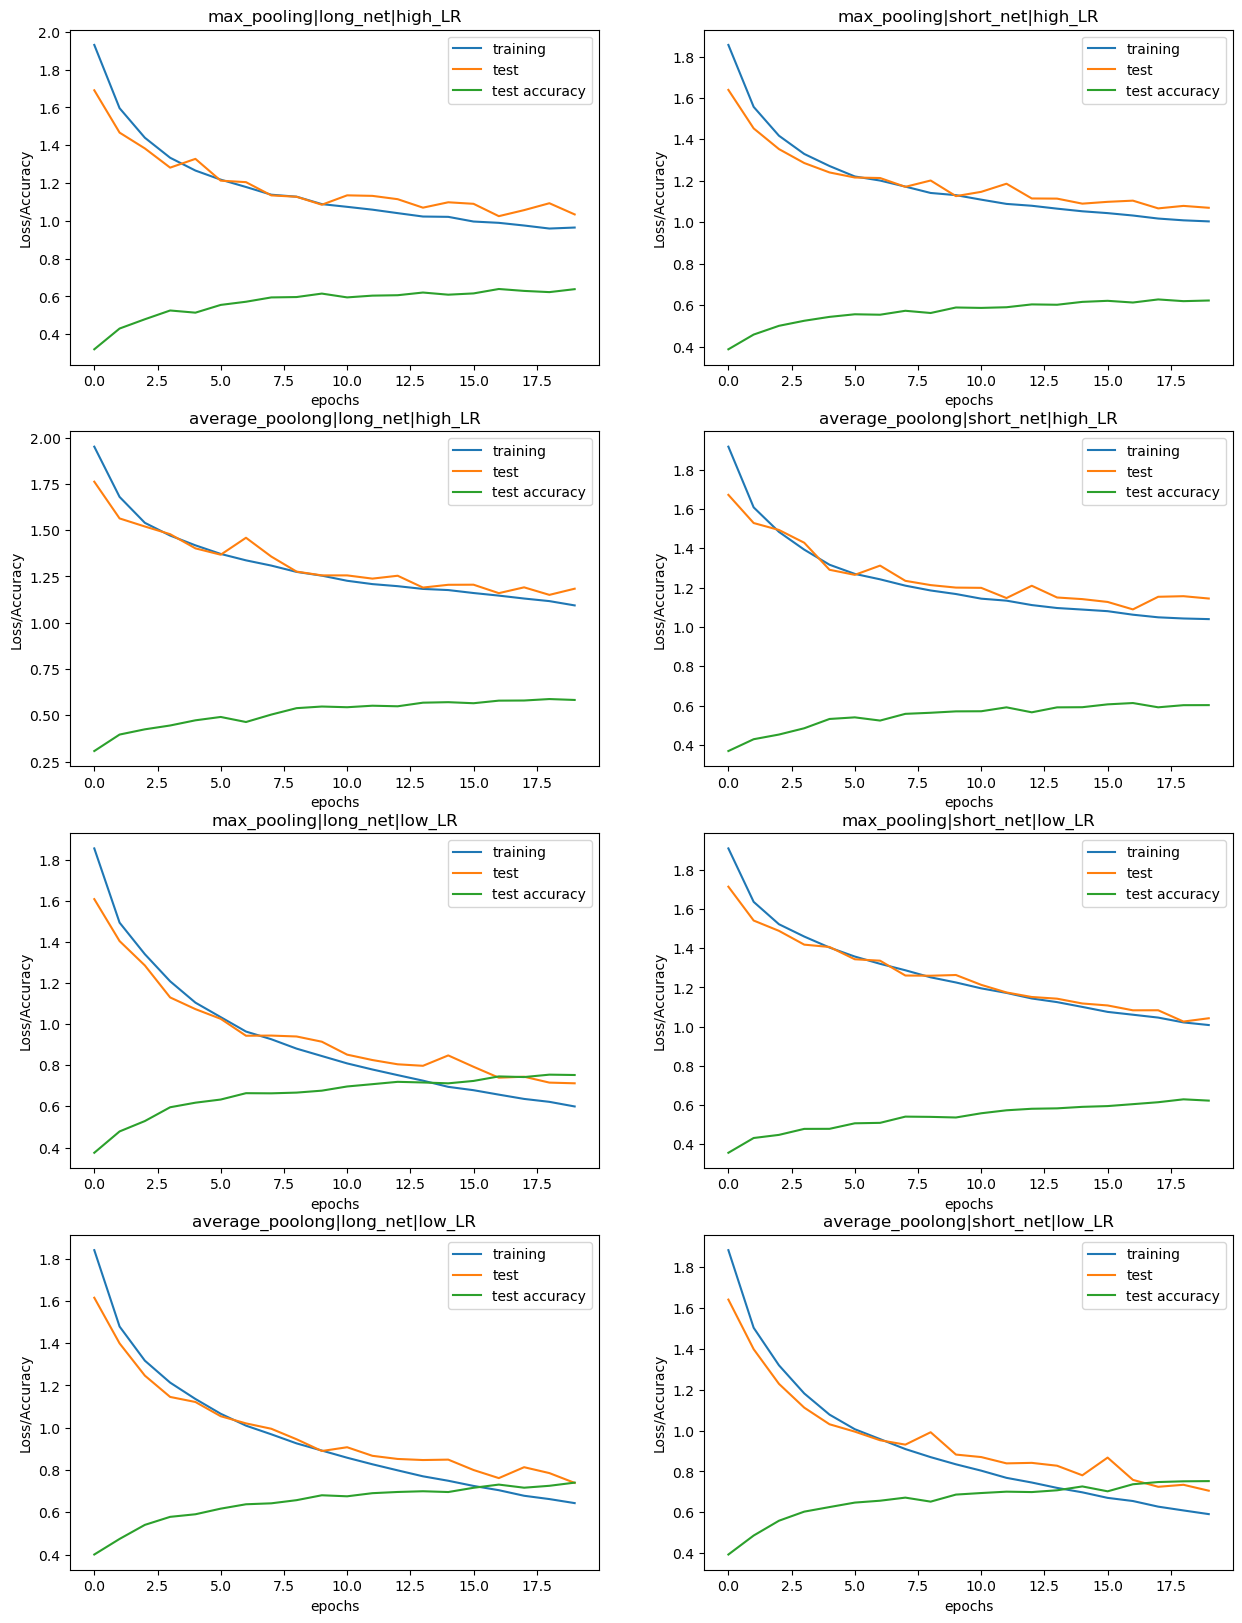

In [7]:
# plotting in a grid

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
for ax, key in zip(axs.flat, plotting.keys()):
    
    train_losses, test_losses, test_accuracies = plotting[key]
    
    line1, = ax.plot(train_losses)
    line2, = ax.plot(test_losses)
    line3, = ax.plot(test_accuracies)
    ax.legend((line1,line2, line3),("training","test", "test accuracy"))
    ax.set_title(key)
    ax.set(xlabel="epochs", ylabel="Loss/Accuracy")
    #ax.label_outer()
    
plt.show()  